# IBM Data Science Professional Capstone Project

This is the capstone project for the IBM Data Science Specialization

In [1]:
import pandas as pd
import numpy as np
import urllib
import json
import folium
import requests
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
%matplotlib inline

In [2]:
toronto_latitude = 43.7032
toronto_longitude = -79.3832

# foursquare credentials
with open('4square.json') as f:
    credentials = json.load(f)
CLIENT_ID = credentials['CLIENT_ID']
CLIENT_SECRET = credentials['CLIENT_SECRET']
VERSION = '20200313'


### Neighborhoods

Let's get information about Toronto neighborhoods from the Toronto Open Data site and draw a map of neighborhoods

In [3]:
# Get the dataset metadata by passing package_id to the package_search endpoint
# For example, to retrieve the metadata for this dataset:

url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "4def3f65-2a65-4a4f-83c4-b2a4aed72d46"}
response = urllib.request.urlopen(url, data=bytes(json.dumps(params), encoding="utf-8"))
package = json.loads(response.read())

# Get the data by passing the resource_id to the datastore_search endpoint
# See https://docs.ckan.org/en/latest/maintaining/datastore.html for detailed parameters options
# For example, to retrieve the data content for the first resource in the datastore:

df = pd.DataFrame()

for idx, resource in enumerate(package["result"]["resources"]):
    site = "https://ckan0.cf.opendata.inter.prod-toronto.ca"
    query = "/api/3/action/datastore_search"
    offset = 0

    if resource["datastore_active"]:
        url = site + query
        p = { "id": resource["id"], "offset": offset }
        r = urllib.request.urlopen(url, data=bytes(json.dumps(p), encoding="utf-8"))
        data = json.loads(r.read())
        df = df.append(data["result"]["records"])
        while len(data["result"]["records"]) > 0:
            links_next = data['result']['_links']['next']
            offset = links_next[links_next.find('offset=')+7:]
            p = { "id": resource["id"], "offset": offset }
            r = urllib.request.urlopen(url, data=bytes(json.dumps(p), encoding="utf-8"))
            data = json.loads(r.read())
            df = df.append(data["result"]["records"])
neighborhoods = df

In [4]:
neighborhoods.head()

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,X,Y,LONGITUDE,LATITUDE,OBJECTID,Shape__Area,Shape__Length,geometry
0,3781,25886861,25926662,49885,094,094,Wychwood (94),Wychwood (94),None,None,-79.425515,43.676919,16491505,3.217960e+06,7515.779658,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4359..."
1,3782,25886820,25926663,49885,100,100,Yonge-Eglinton (100),Yonge-Eglinton (100),None,None,-79.403590,43.704689,16491521,3.160334e+06,7872.021074,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4109..."
2,3783,25886834,25926664,49885,097,097,Yonge-St.Clair (97),Yonge-St.Clair (97),None,None,-79.397871,43.687859,16491537,2.222464e+06,8130.411276,"{""type"": ""Polygon"", ""coordinates"": [[[-79.3911..."
3,3784,25886593,25926665,49885,027,027,York University Heights (27),York University Heights (27),None,None,-79.488883,43.765736,16491553,2.541821e+07,25632.335242,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5052..."
4,3785,25886688,25926666,49885,031,031,Yorkdale-Glen Park (31),Yorkdale-Glen Park (31),None,None,-79.457108,43.714672,16491569,1.156669e+07,13953.408098,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4396..."


In [5]:
neighborhoods.shape

(140, 16)

In [6]:
# cleanup
neighborhoods = neighborhoods[['AREA_SHORT_CODE', 'AREA_NAME', 'LONGITUDE', 'LATITUDE']].copy()
neighborhoods.columns = neighborhoods.columns.str.lower()
neighborhoods.rename(columns={'area_short_code': 'code', 'area_name': 'neighborhood'}, inplace=True)

In [7]:
def remove_number_from_area_name(area_name):
    pos = area_name.find(' (')
    if pos < 0:
        return area_name
    return area_name[:pos]

In [8]:
neighborhoods['neighborhood'] = neighborhoods['neighborhood'].apply(remove_number_from_area_name)
neighborhoods.sort_values(by='code', inplace=True)
neighborhoods.set_index('code', inplace=True)
neighborhoods.index = neighborhoods.index.astype('int64')
neighborhoods.shape

(140, 3)

In [9]:
neighborhoods.head()

,neighborhood,longitude,latitude
code,,,
1,West Humber-Clairville,-79.596356,43.716180
2,Mount Olive-Silverstone-Jamestown,-79.587259,43.746868
3,Thistletown-Beaumond Heights,-79.563491,43.737988
4,Rexdale-Kipling,-79.566228,43.723725
5,Elms-Old Rexdale,-79.548983,43.721519


In [10]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(neighborhoods['latitude'], neighborhoods['longitude'], neighborhoods['neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Features

We will use foursquare data for our analysis, so it is important to understand available categories for venues. We can use these categories as our features.

In [11]:
url = f'https://api.foursquare.com/v2/venues/categories?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}'
# make the GET request
results = requests.get(url).json()

Categories have a deep hierarchy, so we will use a graph to represent it. But we will store categories in the dictionary to simplify search.

In [12]:
class Category:
    def __init__(self, cat_id, name, parent_id=None):
        self.cat_id = cat_id
        self.name = name
        self.parent_id = parent_id

In [13]:
def process_subcategories(cat, parent_id, categories):
    for el in cat['categories']:
        categories[el['id']] = Category(el['id'], el['shortName'], parent_id)
        process_subcategories(el, el['id'], categories)

In [14]:
categories = {}
process_subcategories(results['response'], None, categories)

How many different categories do we have?

In [15]:
len(categories)

941

This is too many. Let's take a look at the highest level of categories:

In [16]:
main_categories = []
for el in categories.values():
    if el.parent_id is None:
        main_categories.append(el.name)
main_categories

['Arts & Entertainment',
 'College & Education',
 'Event',
 'Food',
 'Nightlife',
 'Outdoors & Recreation',
 'Professional',
 'Residence',
 'Shops',
 'Travel']

This level of categories looks like better fit for our purposes. Let's use this list as our features apart from events and residences.

In [17]:
features = main_categories.copy()
features.remove('Event')
features.remove('Residence')
features

['Arts & Entertainment',
 'College & Education',
 'Food',
 'Nightlife',
 'Outdoors & Recreation',
 'Professional',
 'Shops',
 'Travel']

### Venues

Let's get venues data to enrich our dataset with features.

First, we need a simple helper function to get venues for a particular neighborhood.

In [18]:
def getNearbyVenues(codes, latitudes, longitudes, radius=500, limit=500):
    
    venues_list=[]
    for code, lat, lng in zip(codes, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = f'https://api.foursquare.com/v2/venues/search?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{lng}&radius={radius}&limit={limit}'
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            code, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['id']) for v in results if len(v['categories']) > 0])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['code', 
                  'neigborhood_latitude', 
                  'neigborhood_longitude', 
                  'venue', 
                  'venue_latitude', 
                  'venue_longitude', 
                  'venue_category_id']
    
    return(nearby_venues)

#### getNearbyVenues sample

In [19]:
getNearbyVenues([1], [neighborhoods['latitude'][1]], [neighborhoods['longitude'][1]])

,code,neigborhood_latitude,neigborhood_longitude,venue,venue_latitude,venue_longitude,venue_category_id
0,1,43.71618,-79.596356,Comfort Hotel,43.716058,-79.594135,4bf58dd8d48988d1fa931735
1,1,43.71618,-79.596356,Burger King,43.719967,-79.601043,4bf58dd8d48988d16e941735
2,1,43.71618,-79.596356,Ardene,43.720496,-79.600735,4bf58dd8d48988d102951735
3,1,43.71618,-79.596356,Hudson's Bay,43.720448,-79.600025,4bf58dd8d48988d1f6941735
4,1,43.71618,-79.596356,Woodbine Shopping Centre,43.720109,-79.600787,4bf58dd8d48988d1fd941735
...,...,...,...,...,...,...,...
114,1,43.71618,-79.596356,Fusia,43.720073,-79.600666,4bf58dd8d48988d145941735
115,1,43.71618,-79.596356,Woodbine Ribfest,43.718170,-79.597435,56aa371be4b08b9a8d57350b
116,1,43.71618,-79.596356,Kabob Steak House,43.719986,-79.600920,4bf58dd8d48988d1c0941735
117,1,43.71618,-79.596356,Canes Family Health Team,43.716920,-79.592241,4bf58dd8d48988d177941735


This helper function can get a highest level category for any category. It is necessary for us as we are going to use only the highest level of categories.

In [20]:
def get_venue_type(cat_id, categories):
    cat = categories[cat_id]
    while cat.parent_id:
        cat = categories[cat.parent_id]
    return cat.name

#### get_venue_type sample

In [21]:
get_venue_type('4d954b0ea243a5684a65b473', categories)

'Shops'

As we have a limited number of API requests to Foursquare API let's save data to a file. For the first run it will download the data and store it. If you want to refresh it - just delete the file.

In [22]:
# save api requests
if not os.path.exists('venues.csv'):
    venues = getNearbyVenues(neighborhoods.index, neighborhoods['latitude'], neighborhoods['longitude'])
    venues.to_csv('venues.csv')

venues = pd.read_csv('venues.csv', usecols=np.arange(1, 8))    

Let's apply the get_venue_type to the data

In [23]:
venues['venue_category'] = venues['venue_category_id'].apply(get_venue_type, categories=categories)

In [24]:
venues

,code,neigborhood_latitude,neigborhood_longitude,venue,venue_latitude,venue_longitude,venue_category_id,venue_category
0,1,43.716180,-79.596356,Comfort Hotel,43.716058,-79.594135,4bf58dd8d48988d1fa931735,Travel
1,1,43.716180,-79.596356,Burger King,43.719967,-79.601043,4bf58dd8d48988d16e941735,Food
2,1,43.716180,-79.596356,Taco Bell,43.719858,-79.600984,4bf58dd8d48988d1c4941735,Food
3,1,43.716180,-79.596356,Thai Express,43.720631,-79.600025,4bf58dd8d48988d149941735,Food
4,1,43.716180,-79.596356,Ardene,43.720496,-79.600735,4bf58dd8d48988d102951735,Shops
...,...,...,...,...,...,...,...,...
14192,140,43.748829,-79.195055,Rosa & Spencer Clark Parkette,43.743638,-79.202835,4bf58dd8d48988d163941735,Outdoors & Recreation
14193,140,43.748829,-79.195055,mariland travel guildwood,43.746756,-79.200374,4bf58dd8d48988d1f6931735,Travel
14194,140,43.748829,-79.195055,Ritz Caribbean Foods,43.751699,-79.204168,4bf58dd8d48988d144941735,Food
14195,140,43.748829,-79.195055,Prominence Point,43.752411,-79.204078,4d954b06a243a5684965b473,Residence


Let's count all venue types for each district. This dataframe will serve as our main datasource.

In [25]:
neighborhoods_data = neighborhoods.copy()
# add features to dataset
for cat in features:
    neighborhoods_data[cat] = 0

# calculate venues
for ind, row in venues.iterrows():
    venue_cat = row['venue_category']
    if venue_cat in features:
        code = row['code']
        neighborhoods_data.loc[code, venue_cat] += 1

In [26]:
neighborhoods_data.head()

,neighborhood,longitude,latitude,Arts & Entertainment,College & Education,Food,Nightlife,Outdoors & Recreation,Professional,Shops,Travel
code,,,,,,,,,,,
1,West Humber-Clairville,-79.596356,43.716180,4,1,38,0,3,15,52,5
2,Mount Olive-Silverstone-Jamestown,-79.587259,43.746868,2,2,26,1,1,20,32,3
3,Thistletown-Beaumond Heights,-79.563491,43.737988,2,3,32,2,2,17,32,2
4,Rexdale-Kipling,-79.566228,43.723725,6,1,22,2,5,36,33,6
5,Elms-Old Rexdale,-79.548983,43.721519,1,0,32,2,7,17,38,8


### Exploratory Data Analysis (EDA)

First, let's take a look at average number of different venue types per neighborhood

In [27]:
neighborhoods_data[features].mean()

Arts & Entertainment      3.914286
College & Education       2.378571
Food                     19.364286
Nightlife                 3.028571
Outdoors & Recreation     9.214286
Professional             23.800000
Shops                    29.642857
Travel                    4.471429
dtype: float64

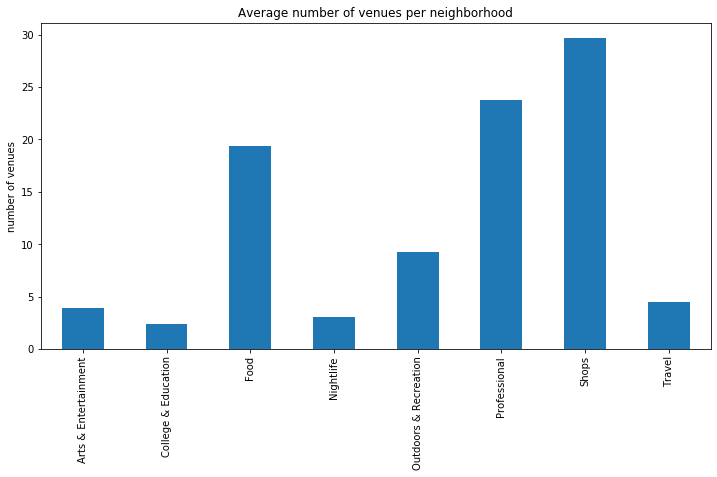

In [28]:
ax = neighborhoods_data[features].mean().plot.bar(title='Average number of venues per neighborhood', figsize=(12,6))
ax.set_ylabel('number of venues')
plt.show()

Let's take a look at their distribution

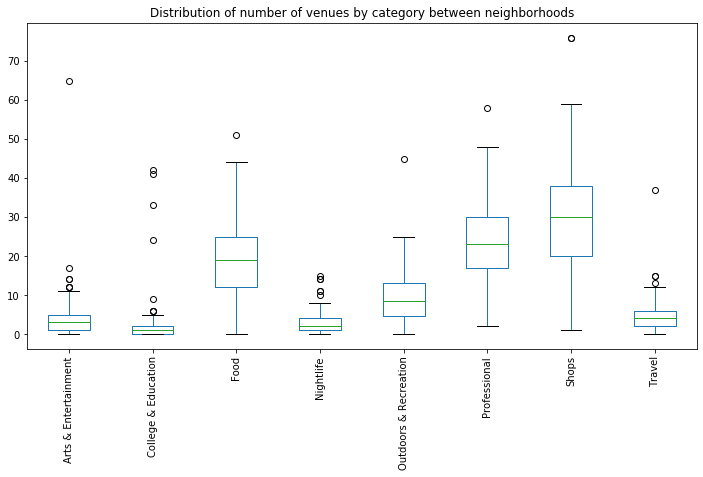

In [29]:
ax = neighborhoods_data[features].plot.box(rot=90, title='Distribution of number of venues by category between neighborhoods', figsize=(12,6))
plt.show()

We can see that the variance of features is different. Let's look at particular values of the standard deviation of these features.

In [30]:
neighborhoods_data[features].std()

Arts & Entertainment      6.060232
College & Education       5.968102
Food                      9.781211
Nightlife                 2.851083
Outdoors & Recreation     6.322036
Professional              9.488501
Shops                    13.692445
Travel                    4.004391
dtype: float64

"Shops", "Professional",  and "Food" are the categories with the highest variance. Let's take a look at their distribution. A red vertical line is an average value.

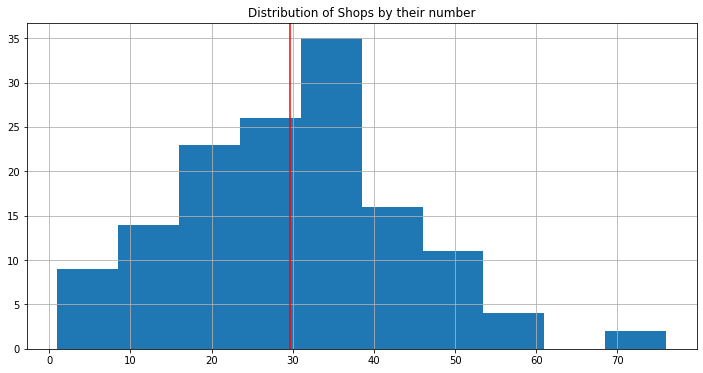

In [31]:
ax = neighborhoods_data['Shops'].hist(figsize=(12, 6))
ax.set_title('Distribution of Shops by their number')
ax.axvline(neighborhoods_data[features].mean()['Shops'], c='r')
plt.show()

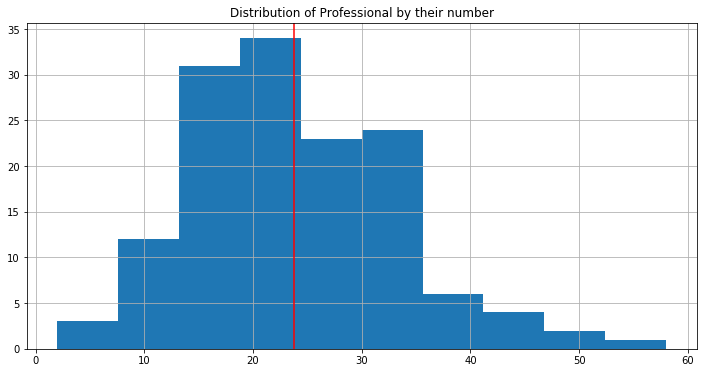

In [32]:
ax = neighborhoods_data['Professional'].hist(figsize=(12, 6))
ax.set_title('Distribution of Professional by their number')
ax.axvline(neighborhoods_data[features].mean()['Professional'], c='r')
plt.show()

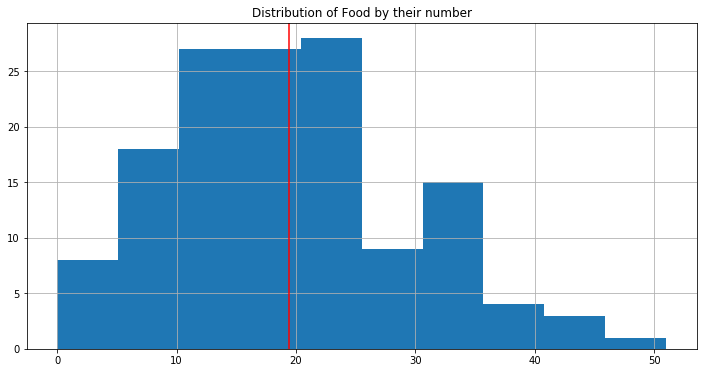

In [33]:
ax = neighborhoods_data['Food'].hist(figsize=(12, 6))
ax.set_title('Distribution of Food by their number')
ax.axvline(neighborhoods_data[features].mean()['Food'], c='r')
plt.show()

All three distributions look reasonable: peak in the middle and skewed to the right. We can consider it as a normal one.

Let's take a look at correlations of the number of venues by neighborhood.

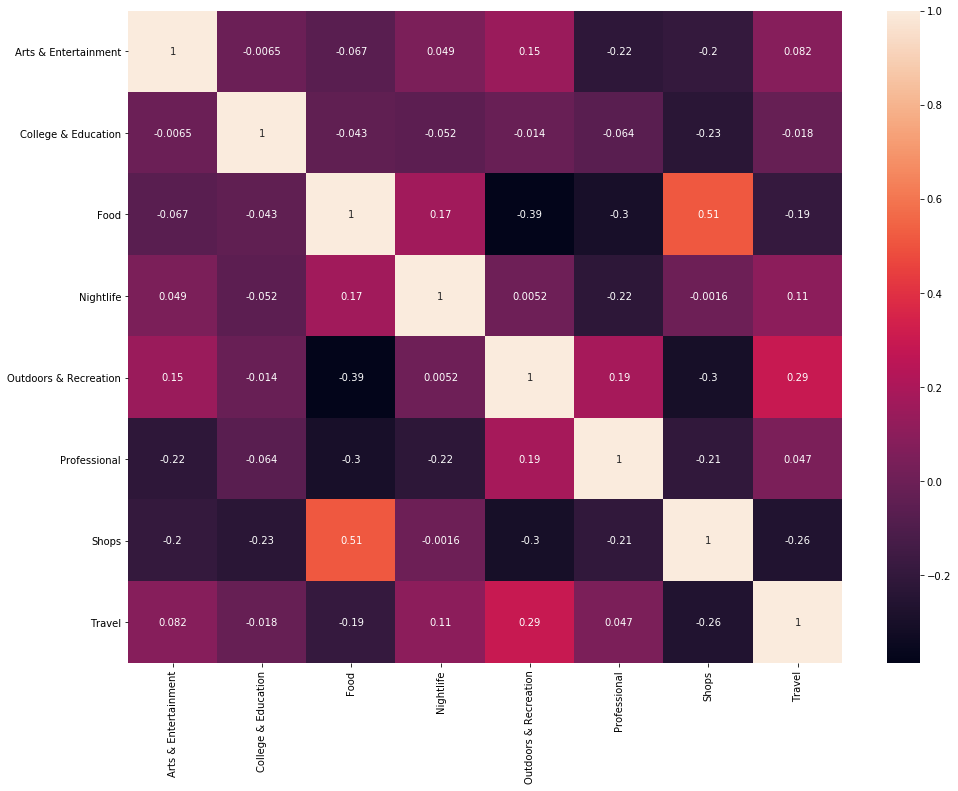

In [34]:
# correlations for eating
corr_matrix = neighborhoods_data[features].corr()
fig, ax = plt.subplots(figsize=(16, 12))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

We can see a small positive correlation between Food and Shops categories, which is pretty reasonable. There are no strong correlations between these features, so we can use all of them for our analysis.

### Target values

The objective of this task is to help a family who is moving to Toronto to select an optimal neighborhood for their needs. Considering that all families have different needs, we will set up parameters for some "standard" family. However, these parameters can be adjusted in any way for other families.
To select parameters, we need to understand how the family values different features. To do this, we will ask to set up parameters on a scale 0..100, where 0 means: "I don't want to have such venues in the neighborhood", and 100 says, "I want the available maximum of these venues in the neighborhood."

In [35]:
# YOU CAN CHANGE THESE PARAMETERS FOR YOUR PURPOSE
arts_and_entertainment = 80 # the family likes arts and entertainment
college_and_education = 50 # they consider nearby colleges as not important
food = 80 # restraunts and coffee_shops are important
nightlife = 0 # they dislike nightlife and want to avoid it
outdoors_and_recreation = 90 # outdoors and recreations are very important
professional = 20 # they prefer residential areas, these will limit business districts but will keep some local businesses
shops = 60 # they want to have some variety of shops, but not too much
travel = 0 # travel amenities could bring disturbance and they want to avoid them

target_values = {
    'Arts & Entertainment': arts_and_entertainment,
    'College & Education': college_and_education,
    'Food': food,
    'Nightlife': nightlife,
    'Outdoors & Recreation': outdoors_and_recreation,
    'Professional': professional,
    'Shops': shops,
    'Travel': travel
}

### Data preprocessing

First of all we need to normalize the data, as the number of venues is very different between categories.

In [36]:
feature_scalers = {}
for feature in features:
    feature_scalers[feature] = StandardScaler()
    feature_scalers[feature].fit(neighborhoods_data[feature].values.reshape(-1, 1))

In [37]:
neighborhoods_norm = neighborhoods_data.copy()
for feature in features:
    neighborhoods_norm[feature] = feature_scalers[feature].transform(neighborhoods_norm[feature].values.reshape(-1, 1))

In [38]:
neighborhoods_norm.head()

,neighborhood,longitude,latitude,Arts & Entertainment,College & Education,Food,Nightlife,Outdoors & Recreation,Professional,Shops,Travel
code,,,,,,,,,,,
1,West Humber-Clairville,-79.596356,43.716180,0.014195,-0.231819,1.912097,-1.066067,-0.986486,-0.930768,1.638672,0.132472
2,Mount Olive-Silverstone-Jamestown,-79.587259,43.746868,-0.317011,-0.063660,0.680850,-0.714064,-1.303976,-0.401923,0.172767,-0.368773
3,Thistletown-Beaumond Heights,-79.563491,43.737988,-0.317011,0.104499,1.296474,-0.362061,-1.145231,-0.719230,0.172767,-0.619396
4,Rexdale-Kipling,-79.566228,43.723725,0.345400,-0.231819,0.270435,-0.362061,-0.668996,1.290384,0.246063,0.383094
5,Elms-Old Rexdale,-79.548983,43.721519,-0.482614,-0.399978,1.296474,-0.362061,-0.351506,-0.719230,0.612539,0.884340


As we have normalized the data, we need to normalize our target_values. First we need to scale the value by our target coefficient and then normalize it by the feature scaler.

In [39]:
target_values_norm = {}
for feature in features:
    target = np.percentile(neighborhoods_data[feature], target_values[feature])
    target_values_norm[feature] = feature_scalers[feature].transform(np.array(target).reshape(-1, 1))[0][0]
target_values_norm

{'Arts & Entertainment': 0.1797971950648584,
 'College & Education': -0.23181933066201452,
 'Food': 0.701371111775053,
 'Nightlife': -1.0660671961357695,
 'Outdoors & Recreation': 1.2359420611099186,
 'Professional': -0.740384028647716,
 'Shops': 0.17276729197101026,
 'Travel': -1.1206407611166134}

### Cluster neighborhoods

It is reasonable to cluster neighborhoods into similar groups. To do it, we will use the k-means clustering. This will allow us to have a set of possible options that could be reasonable for a particular family. Let's try to find an optimal K to do it.

In [40]:
data = []
for i in np.arange(1, 20):
    X_train, X_test = train_test_split(neighborhoods_norm[features], test_size=0.33, random_state=0)
    n_clusters = i
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_train)
    data.append((np.abs(kmeans.score(X_test))))

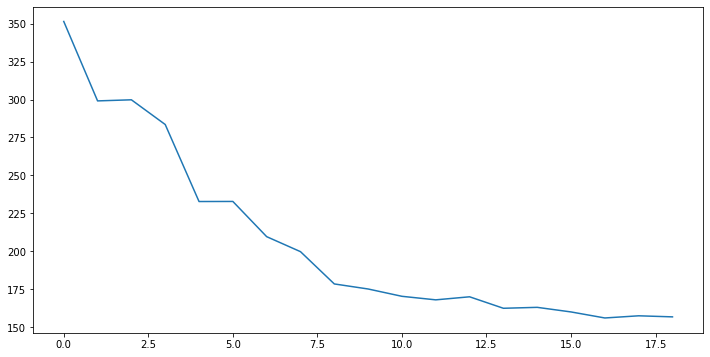

In [41]:
plt.figure(figsize=(12,6))
plt.plot(data)
plt.show()

It looks like we have an "elbow" point approximately near 8, so let's use K=8 to make our clusters.

In [42]:
n_clusters = 8
X = neighborhoods_norm[features]
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
neighborhoods_norm['cluster'] = kmeans.labels_
neighborhoods_data['cluster'] = kmeans.labels_

Let's take a look at our clusters

In [43]:
clusters = pd.DataFrame(columns=features)
for i in range(n_clusters):
    clusters = clusters.append(pd.Series(kmeans.cluster_centers_[i], index=features), ignore_index=True)
clusters

,Arts & Entertainment,College & Education,Food,Nightlife,Outdoors & Recreation,Professional,Shops,Travel
0,-0.119561,-0.231819,1.221494,-0.348522,-0.748369,-0.759911,1.246824,-0.397691
1,-0.267330,-0.167919,-0.152294,-0.369101,-0.126089,0.784807,0.036438,-0.223412
2,0.149130,-0.063660,-0.679602,-0.114355,1.247701,0.314957,-0.571043,0.754387
3,-0.125931,-0.167143,-1.110772,-0.199597,-0.534674,-1.044674,-1.248032,-0.233823
4,10.115958,-0.399978,-0.755605,-1.066067,0.759708,-2.305767,-1.732908,-0.118151
5,1.339016,-0.399978,0.065227,1.749959,2.029666,-0.613461,-1.659613,8.152393
6,0.014195,5.485590,-0.011726,-0.362061,-0.192762,-0.322596,-1.238166,-0.180806
7,0.142997,-0.157082,0.521244,1.886850,-0.166304,-0.566453,0.319358,-0.173845


We need to value our clusters, to do it let's calculate a distance between a cluster center and our target values. We will need a helper function to calculate a distance.

In [44]:
def get_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c

#### get_distance sample

In [45]:
# distance in km between neighborhoods with codes 1 and 2
get_distance(neighborhoods.loc[1, 'latitude'], neighborhoods.loc[1, 'longitude'], neighborhoods.loc[2, 'latitude'], neighborhoods.loc[2, 'longitude'])

3.4907875581047185

In [46]:
clusters['distance'] = clusters[features].apply(lambda x: distance.euclidean(x, list(target_values_norm.values())), axis=1)
clusters.sort_values(by='distance', inplace=True)
clusters

,Arts & Entertainment,College & Education,Food,Nightlife,Outdoors & Recreation,Professional,Shops,Travel,distance
1,-0.267330,-0.167919,-0.152294,-0.369101,-0.126089,0.784807,0.036438,-0.223412,2.534453
0,-0.119561,-0.231819,1.221494,-0.348522,-0.748369,-0.759911,1.246824,-0.397691,2.547379
2,0.149130,-0.063660,-0.679602,-0.114355,1.247701,0.314957,-0.571043,0.754387,2.832830
3,-0.125931,-0.167143,-1.110772,-0.199597,-0.534674,-1.044674,-1.248032,-0.233823,3.188272
7,0.142997,-0.157082,0.521244,1.886850,-0.166304,-0.566453,0.319358,-0.173845,3.416659
6,0.014195,5.485590,-0.011726,-0.362061,-0.192762,-0.322596,-1.238166,-0.180806,6.229774
5,1.339016,-0.399978,0.065227,1.749959,2.029666,-0.613461,-1.659613,8.152393,9.984970
4,10.115958,-0.399978,-0.755605,-1.066067,0.759708,-2.305767,-1.732908,-0.118151,10.401546


We can see that clusters 1 and 0 are both very close to the target values. So, let's find the best neighborhood directly by calculating the distance between the neighborhood and target values

In [47]:
neighborhoods_norm['distance'] = neighborhoods_norm[features].apply(lambda x: distance.euclidean(x, list(target_values_norm.values())), axis=1)
neighborhoods_data['distance'] = neighborhoods_norm['distance']
best = neighborhoods_data.sort_values(by='distance')[:1]
best

,neighborhood,longitude,latitude,Arts & Entertainment,College & Education,Food,Nightlife,Outdoors & Recreation,Professional,Shops,Travel,cluster,distance
code,,,,,,,,,,,,,
19,Long Branch,-79.533345,43.592362,3,3,31,2,12,17,40,2,0,1.478682


### Results and Recommendations

We can plot our recommendations on the map, differentiating neighborhoods by colors, where green=better and red=worse. Also, we will mark the best neighborhood with a blue circle as the best option.

In [48]:
# recommendation order of clusters
recommendation_order = list(clusters.sort_values(by='distance', ascending=False).index)
recommendation_order

# create map
map_clusters = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
colors_array = cm.RdYlGn(np.linspace(0, 1, len(ys)))
color_map = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods_norm['latitude'], neighborhoods_norm['longitude'], neighborhoods_norm['neighborhood'], neighborhoods_norm['cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color_map[recommendation_order.index(cluster)],
        fill=True,
        fill_color=color_map[recommendation_order.index(cluster)],
        fill_opacity=0.7).add_to(map_clusters)

# best neighborhood
folium.CircleMarker(
        [best.latitude, best.longitude],
        radius=10,
        popup=str(best.neighborhood.values[0]) + ' Cluster ' + str(best.cluster.values[0]),
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.3).add_to(map_clusters)
       
map_clusters

### Discussion

We can see that a lot of neighborhoods are quite similar to each other. Let's check the absolute number.

In [49]:
cluster_sizes = neighborhoods_norm[['neighborhood', 'cluster']].groupby('cluster').count()
cluster_sizes.reset_index(inplace=True)
cluster_sizes['order'] = clusters.index[cluster_sizes['cluster']]
cluster_sizes.sort_values(by='order', inplace=True)
cluster_sizes

,cluster,neighborhood,order
1,1,50,0
0,0,26,1
2,2,27,2
3,3,13,3
7,7,18,4
6,6,4,5
5,5,1,6
4,4,1,7


The first three clusters cover 3/4 of the neighborhoods. At the same time, the last three neighborhoods are outliers with some specificity, and until this specificity is required, they will not be recommended. We can see that there are a lot of "yellow" neighborhoods near downtown. It means that these areas do not fit our target values, as they were composed to target an optimal residential area suitable for a family. It can confirm that this type of analysis is working and can be used for the recommendation of neighborhood purposes. And it means that Toronto is a friendly city for family needs.

### Conclusion and Future Directions

Good news! We have a lot of matching neighborhoods for this family all around the city. It means that they have a lot of choices, and can consider other factors, like proximity of job or some other points of interest for the family.
We can see that the best neighborhood is at the border of the city.   
We can consider improving our model by adding coordinates of a point of interest, e.g., job, college, or even downtown coordinates to consider it's proximity as one of the features. Also, we can add other features, like ecological factors, economy factors, and so on.